In [31]:
# RNN - Time Series prediction

import numpy
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
import matplotlib.pyplot as plt

In [ ]:
NUM_OF_PREV_ITEMS=5   # Number of past observations to use

In [ ]:
# reconstruct_data()
# Convert array of values to matrix of features
#   that are previous values in the time series
def reconstruct_data(data_set, n=1):
    x, y = [], []
    
    for i in range(len(data_set) - n - 1):
        a = data_set[i:(i + n), 0]
        x.append(a)
        y.append(data_set[i + n, 0])
        
    return numpy.array(x), numpy.array(y)

In [ ]:
numpy.random.seed(1)

In [ ]:
# load datasets
data_frame = read_csv('daily-min-temperatures.csv',usecols=[1])

In [ ]:
data = data_frame.values
data = data.astype('float32')

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))

In [ ]:
data = scaler.fit_transform(data)

In [ ]:
# split data into train and test sets
train, test = data[0:int(len(data) * 0.7), :], data[int(len(data)*0.7):len(data), :]

In [ ]:
# Construct data
train_x, train_y = reconstruct_data(train, NUM_OF_PREV_ITEMS)
test_x, test_y = reconstruct_data(test, NUM_OF_PREV_ITEMS)

In [ ]:
# reshape input to be [numOfSamples, time steps, numOfFeatures]
#. time steps is  1 because we want it to predict the next value
train_x = numpy.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = numpy.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(1, NUM_OF_PREV_ITEMS)))
model.add(Dropout(0.5))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=50))  # last layer so do not need to return sequences 
model.add(Dropout(0.3))
model.add(Dense(units=1))


In [ ]:
# compile model with ADAM optimizer
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=10, batch_size=16, verbose=2)

In [26]:
# make predictions and min-max normalization
test_predict = model.predict(test_x)
test_predict = scaler.inverse_transform(test_predict)
test_labels = scaler.inverse_transform([test_y])

35/35 [==============================] - 0s 666us/step


In [27]:
test_score = mean_squared_error(test_labels[0], test_predict[:, 0])
print('Score on test set: %.2f MSE' % test_score)

Score on test set: 5.53 MSE


In [28]:
# plot results (original data vs. predictions)
test_predict_plot = numpy.empty_like(data)
test_predict_plot[:, :] = numpy.nan
test_predict_plot[len(train_x)+2*NUM_OF_PREV_ITEMS+1:len(data)-1, :] = test_predict
print(test_predict_plot)

[[      nan]
 [      nan]
 [      nan]
 ...
 [12.901785]
 [13.293312]
 [      nan]]


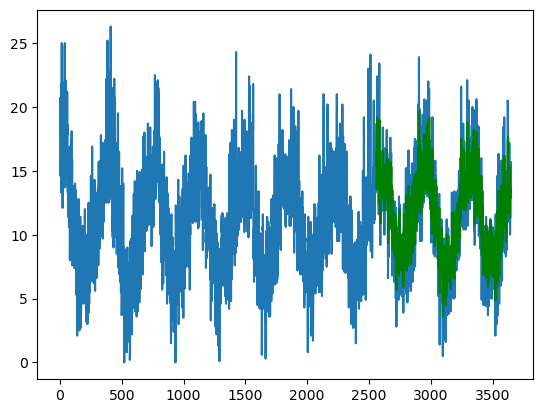

In [32]:
plt.plot(scaler.inverse_transform(data))
plt.plot(test_predict_plot, color="green")
plt.show()

In [ ]:
# Plot above shows predictions overlaid in green